<pre>使用块的网络（VGG）
Open the notebook in Colab
Open the notebook in SageMaker Studio Lab

虽然AlexNet证明深层神经网络卓有成效，但它没有提供一个通用的模板来指导后续的研究人员设计新的网络。 在下面的几个章节中，我们将介绍一些常用于设计深层神经网络的启发式概念。

与芯片设计中工程师从放置晶体管到逻辑元件再到逻辑块的过程类似，神经网络架构的设计也逐渐变得更加抽象。研究人员开始从单个神经元的角度思考问题，发展到整个层，现在又转向块，重复层的模式。

使用块的想法首先出现在牛津大学的视觉几何组（visual geometry group）的VGG网络中。通过使用循环和子程序，可以很容易地在任何现代深度学习框架的代码中实现这些重复的架构

<pre>VGG块

经典卷积神经网络的基本组成部分是下面的这个序列：

    带填充以保持分辨率的卷积层；

    非线性激活函数，如ReLU；

    汇聚层，如最大汇聚层。
而一个VGG块与之类似，由一系列卷积层组成，后面再加上用于空间下采样的最大汇聚层。在最初的VGG论文中 (Simonyan and Zisserman, 2014)，  
作者使用了带有 3*3卷积核、填充为1（保持高度和宽度）的卷积层，和带有2*2汇聚窗口、步幅为2（每个块后的分辨率减半）的最大汇聚层。  
在下面的代码中，我们定义了一个名为vgg_block的函数来实现一个VGG块。  
该函数有三个参数，分别对应于卷积层的数量num_convs、输入通道的数量in_channels 和输出通道的数量out_channels.

In [7]:
import torch
from torch import nn
from d2l import torch as d2l

#输入输出chanel可以定义，size减半
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)


VGG网络  
与AlexNet、LeNet一样，VGG网络可以分为两部分：第一部分主要由卷积层和汇聚层组成，第二部分由全连接层组成。
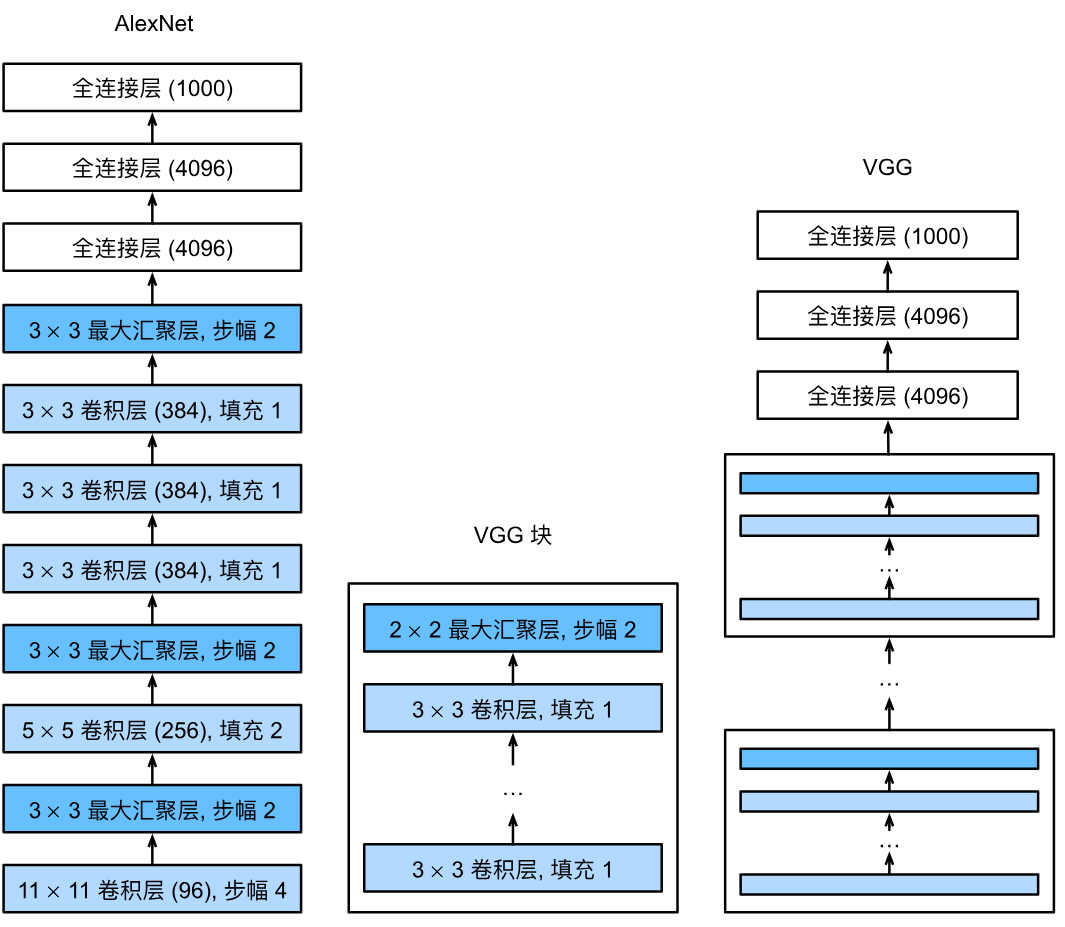
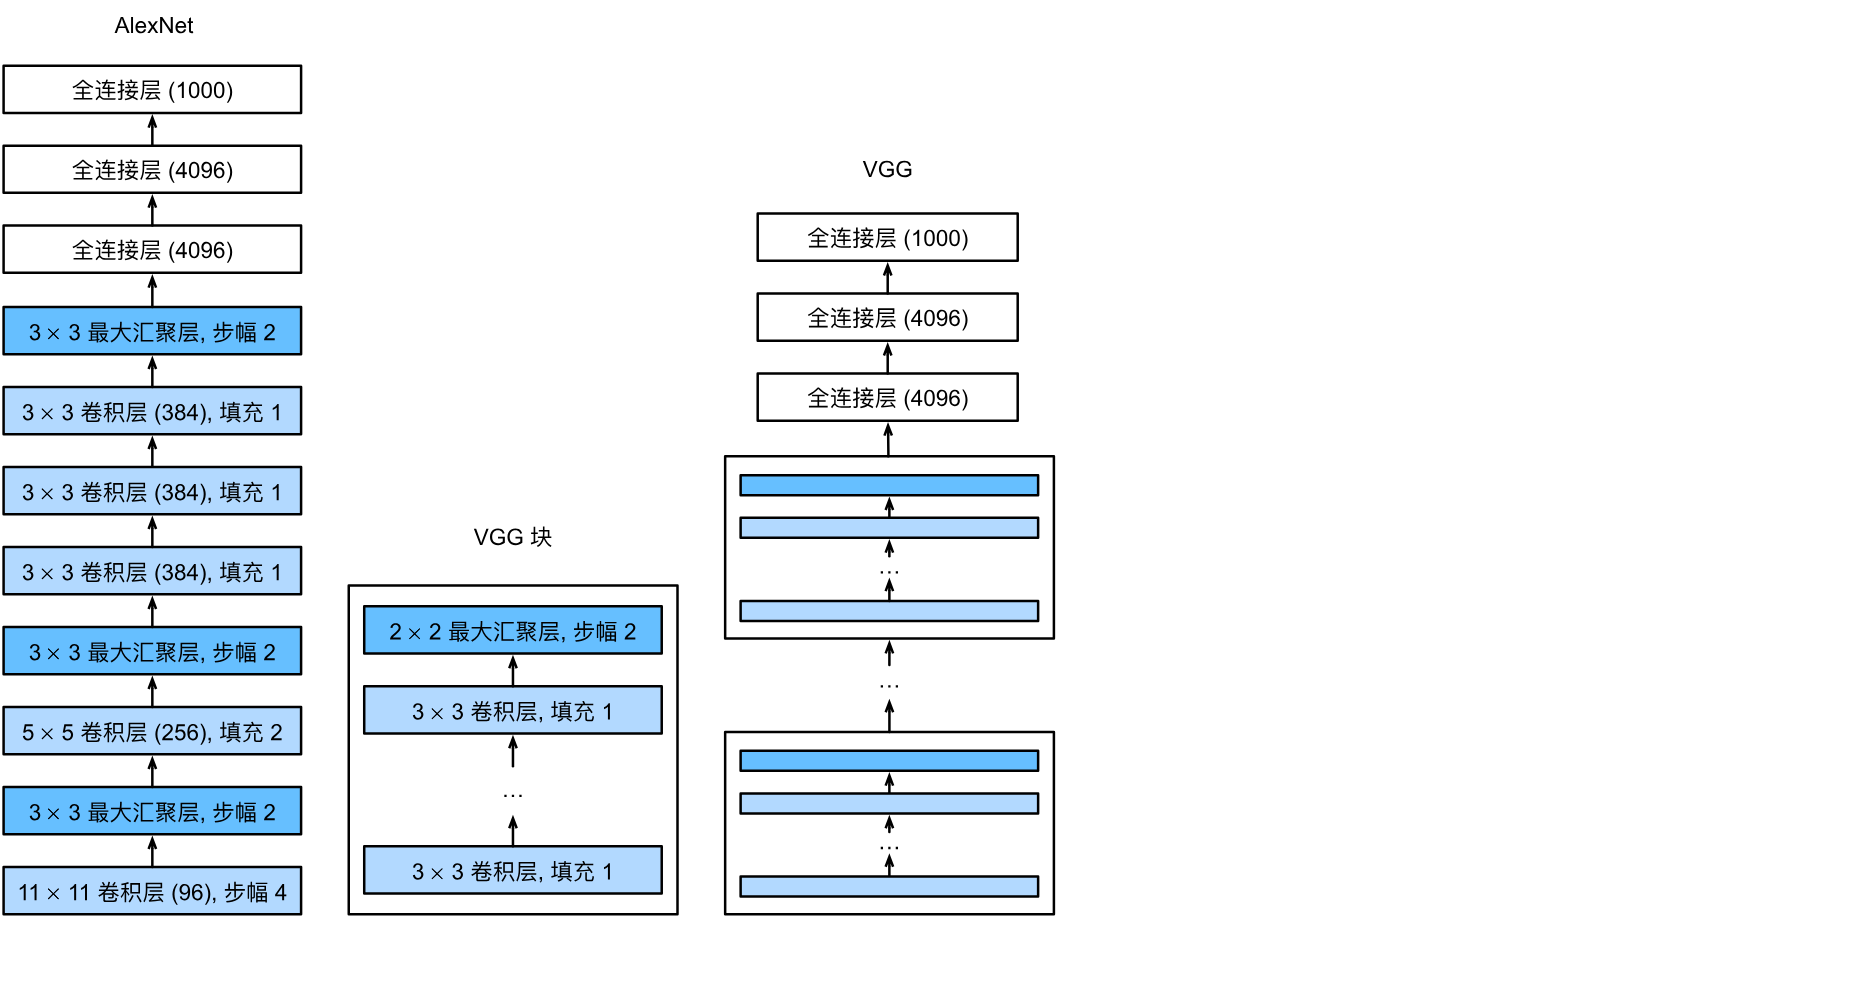

VGG神经网络连接上图的几个VGG块（在vgg_block函数中定义）。其中有超参数变量conv_arch。  
该变量指定了每个VGG块里卷积层个数和输出通道数。全连接模块则与AlexNet中的相同。  

原始VGG网络有5个卷积块，其中前两个块各有一个卷积层，后三个块各包含两个卷积层。   
第一个模块有64个输出通道，每个后续模块将输出通道数量翻倍，直到该数字达到512。  
由于该网络使用8个卷积层和3个全连接层，因此它通常被称为VGG-11。

In [8]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

In [9]:
def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    # 卷积层部分
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels
    #输出size/(2^5)=size/32
    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # 全连接层部分
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10))

net = vgg(conv_arch)

接下来，我们将构建一个高度和宽度为224的单通道数据样本，以观察每个层输出的形状。

In [10]:
X = torch.randn(size=(1, 1, 224, 224))
#224/32=7
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)


Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


训练模型

由于VGG-11比AlexNet计算量更大，因此我们构建了一个通道数较少的网络，足够用于训练Fashion-MNIST数据集。

In [ ]:
ratio = 16
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)


train_loss 0.188,test_loss 0.240, train acc 0.931, test acc 0.915
590.3 examples/sec on cuda:0


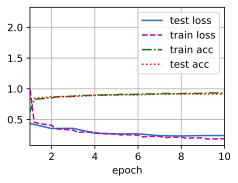

In [12]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())
